# Integrales de camino usando Algorimo de Metrópolis

Elaborado por: Lucas Quiceno and Jhoan Eusse

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
plt.style.use("ggplot")
from scipy import constants

In [68]:
#Global variables

#physics constants

h_bar = 1 #plank's constant over 2*pi (in natural units)
m = 1 #mass of the oscillator
omega = 1 #natural frequency of the oscillator

#iteration variables

N = 5     
delta = 1
n_bar = 5

#betas used to calculate energy using Metropolis algorithm
betas_1 = np.array([.1,.3,.5,.7,.9,2,4,6,8,10]) 

#betas  to calculate exact value of energy using the partition function of the oscillator
betas_2 = np.linspace(.01,10,100) 

#Average energy arrays
H_avg1 = np.zeros(np.size(betas_1))
H_avg2 = np.zeros(np.size(betas_1))
H_avg3 = np.zeros(np.size(betas_1))
H_avg4 = np.zeros(np.size(betas_1))
H_avg5 = np.zeros(np.size(betas_1))
H_avg6 = np.zeros(np.size(betas_1))

#Number of Metropolis steps
num_steps1 = np.linspace(2, 20, 10, endpoint=True).astype(int)
num_steps2 = np.linspace(20, 200, 10, endpoint=True).astype(int)
num_steps3 = np.linspace(20, 200, 10, endpoint=True).astype(int)
num_steps4 = np.linspace(200, 2000, 10, endpoint=True).astype(int)
num_steps5 = np.linspace(2000, 20000, 10, endpoint=True).astype(int)
num_steps6 = np.linspace(20000, 200000, 10, endpoint=True).astype(int)

In [69]:
class PathIntegral:
    """
    This class implements the path integral Monte Carlo simulation
    of a harmonic oscillator.
    """

    def __init__(self, m=1, omega=1):
        """
        Initializes the class with mass (m) and frequency (omega) of the oscillator.

        Args:
            m (float, optional): Mass of the oscillator. Defaults to 1.
            omega (float, optional): Frequency of the oscillator. Defaults to 1.
        """
        self.m = m
        self.omega = omega

    def potencial(self, q):
        """
        Calculates the potential energy of the oscillator.

        Args:
            q (numpy.ndarray): Array of positions.

        Returns:
            float: Total potential energy.
        """
        return 0.5 * self.m * (self.omega**2) * (q**2)

    def gradient(self, q):
        """
        Calculates the gradient of the potential energy.

        Args:
            q (numpy.ndarray): Array of positions.

        Returns:
            numpy.ndarray: Array of forces (derivative of potential w.r.t. positions).
        """
        return self.m * (self.omega**2) * q

    def Lagrangian(self, q):
        """
        Calculates the Lagrangian of the system (kinetic + potential energy).

        Args:
            q (numpy.ndarray): Array of positions.

        Returns:
            float: Total Lagrangian.
        """
        N = np.size(q)
        term = self.potencial(q) + (0.5 * q * self.gradient(q))
        return np.sum(term) / N

    def Evolution(self, q, beta):
        """
        Calculates the action (integral of Lagrangian) for a path.

        Args:
            q (numpy.ndarray): Array of positions.
            beta (float): Inverse temperature.

        Returns:
            float: Total action.
        """
        N = np.size(q)
        term = np.zeros(N)

        for i in range(N - 1):
            term[i] = (self.m * (q[i + 1] - q[i])**2) / (2 * (beta / N) * (h_bar**2)) + (beta / N) * self.potencial(q[i])

        term[N - 1] = (self.m * (q[0] - q[N - 1])**2) / (2 * (beta / N) * (h_bar**2)) + (beta / N) * self.potencial(q[i])

        return np.sum(term)

    def probability(self, Evolution):
        """
        Calculates the probability of a path based on its action.

        Args:
            Evolution (float): Action of the path.

        Returns:
            float: Probability of the path.
        """
        return np.exp(-Evolution)


    def initial_config(self, N):
        """
        Generates a random initial configuration of positions.

        Args:
            N (int): Number of positions in the path.

        Returns:
            numpy.ndarray: Array of initial positions.
        """
        return np.random.uniform(-1, 1, N)


    def path_integral_mcmc(self, q, beta, num_steps, delta=1, n_bar=5):
        """
        Performs a Path Integral Monte Carlo simulation using the Metropolis algorithm.

        Args:
            q (numpy.ndarray): Initial configuration of positions.
            beta (float): Inverse temperature.
            num_steps (int): Number of Monte Carlo steps.
            delta (float, optional): Step size for proposing new positions. Defaults to 1.
            n_bar (int, optional): Number of sweeps within a single Monte Carlo step for better mixing. Defaults to 5.

        Returns:
            tuple: (q_final, H_avg)
                - q_final (numpy.ndarray): Final configuration of positions after the simulation.
                - H_avg (numpy.ndarray): Array of average Lagrangian (approximating energy) at each step.
        """
        # Get the size of the array q
        N = np.size(q)

        # Initialize an array of zeros with the same size as q
        q_proposed = np.zeros(N)  

        # Calculate the current probability using the Evolution function
        p_current = self.probability(self.Evolution(q, beta))

        # Initialize the proposed probability to 0
        p_proposed = 0

        # Initialize an array to store the average Energy
        H_avg = np.zeros(num_steps)

        # Calculate the initial average Energy using the Lagrangian function
        H_avg[0] = self.Lagrangian(q)

        # Start the Metropolis algorithm
        for i in range(num_steps - 1):
            # Iterate over each element in q
            for j in range(N):
                # Iterate over each step in the Metropolis algorithm
                for k in range(n_bar):
                    # Copy the current state of q to q_proposed
                    q_proposed = np.copy(q)
                    
                    # Propose a new state by adding a random number to the current state
                    q_proposed[j] = np.random.uniform(q[j] - delta, q[j] + delta)

                    # Calculate the proposed probability using the Evolution function
                    p_proposed = self.probability(self.Evolution(q_proposed, beta))

                    # If the proposed state minimize The Action
                    if np.random.rand() < min(1, p_proposed / p_current):
                        q[j] = q_proposed[j]
                        p_current = self.probability(self.Evolution(q, beta))

            # Update the average Energy
            H_avg[i + 1] = H_avg[i] + (self.Lagrangian(q) - H_avg[i]) / (i + 2)

        # Return the final state and the average Energy
        return q, H_avg

In [71]:
#Auxiliar functions

def exact_H(beta, omega = 1):
        """
        Calculates the exact value of the Hamiltonian for a harmonic oscillator.

        Args:
            beta (float): Inverse temperature.

        Returns:
            float: Exact value of the Hamiltonian.
        """
        return (h_bar * omega) * (0.5 + (np.exp(beta*h_bar*omega)-1)**-1)


def error(H_avg):
      """
            Calculates the percentage error between the average energy and the exact value.

            Args:
                H_avg (numpy.ndarray): Array of average energy at each step.

            Returns:
                tuple: (percent_diff, avg)
                    - percent_diff (numpy.ndarray): Array of percentage difference at each step.
                    - avg (float): Average percentage
      """
      H_avg_exact_2 = exact_H(betas_1)
      percent_diff = (np.abs(H_avg_exact_2 - H_avg)/H_avg_exact_2)*100
      avg = np.sum(percent_diff)/np.size(percent_diff)
      return percent_diff, avg

In [ ]:
#Iteration

pi = PathIntegral(m=1, omega=1) #define an object of the PathIntegral class

#obtain the position and energy for betas .1,.3,.5,.7,.9,2,4,6,8,10 
for i in range(np.size(betas_1)): 
  q = pi.initial_config(N)
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps1[i]) #iterate for max 20 Metropolis steps 
  H_avg1[i] = H[-1]
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps2[i]) #iterate for max 200 Metropolis steps 
  H_avg2[i] = H[-1]
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps3[i]) #iterate for max 200 Metropolis steps 
  H_avg3[i] = H[-1]
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps4[i]) #iterate for max 2000 Metropolis steps 
  H_avg4[i] = H[-1]
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps5[i]) #iterate for max 20000 Metropolis steps 
  H_avg5[i] = H[-1]
  q, H = pi.path_integral_mcmc(q,betas_1[i],num_steps6[i]) #iterate for max 200000 Metropolis steps
  H_avg6[i] = H[-1]

In [73]:
H_avg_exact = exact_H(betas_2) #Calculate the exact value of the energy fro the different betas

In [83]:
#Calculation of errors for different Metropolis steps 

percent_diff1 , avg1= error(H_avg1) #for max 20 Metropolis steps
percent_diff2 , avg2= error(H_avg2) #for max 200 Metropolis steps
percent_diff3 , avg3= error(H_avg3) #for max 200 Metropolis steps
percent_diff4 , avg4= error(H_avg4) #for max 2000 Metropolis steps 
percent_diff5 , avg5= error(H_avg5) #for max 20000 Metropolis steps
percent_diff6 , avg6= error(H_avg6) #for max 200000 Metropolis steps

## Graficas de la energía para diferentes números de N max

In [75]:
def plot(H_avg, percent_diff, num_steps, betas_1, betas_2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].scatter(betas_1, H_avg, color='red', label="MC")
    axs[0].plot(betas_2, H_avg_exact, color='blue', linestyle="--", label="Exacto")
    axs[0].set_xlabel(r" $\beta (1/k_{B} T)$")
    axs[0].set_ylabel(r" $\beta (1/k_{B} T)$")
    axs[0].set_title(r"$\langle \hat{H} \rangle$ en función de $\beta$", fontsize=18)
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(percent_diff, num_steps, color='red', linestyle='', marker='o', label='$\Delta E$')
    axs[1].set_xlabel('$\Delta E$')
    axs[1].set_ylabel('Número de puntos')
    axs[1].set_title(f'Error con máximo N = {num_steps[9]} puntos')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

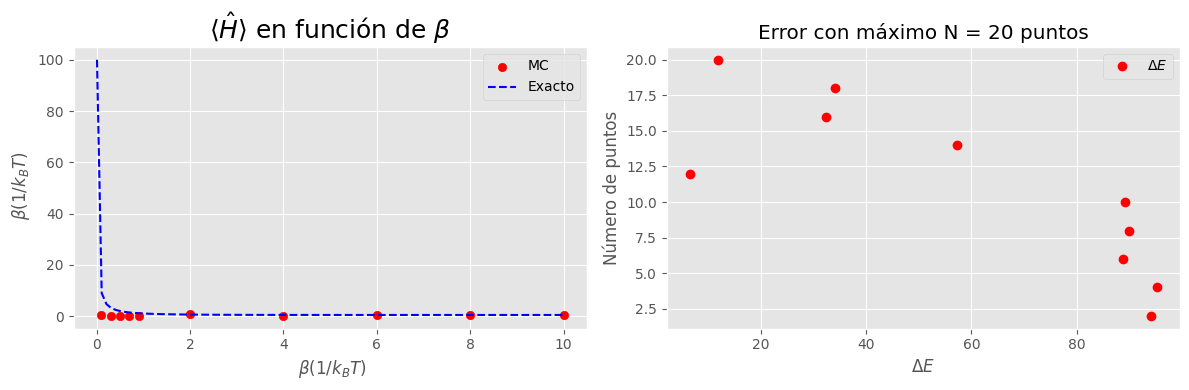

In [77]:
plot(H_avg1, percent_diff1, num_steps1, betas_1, betas_2)

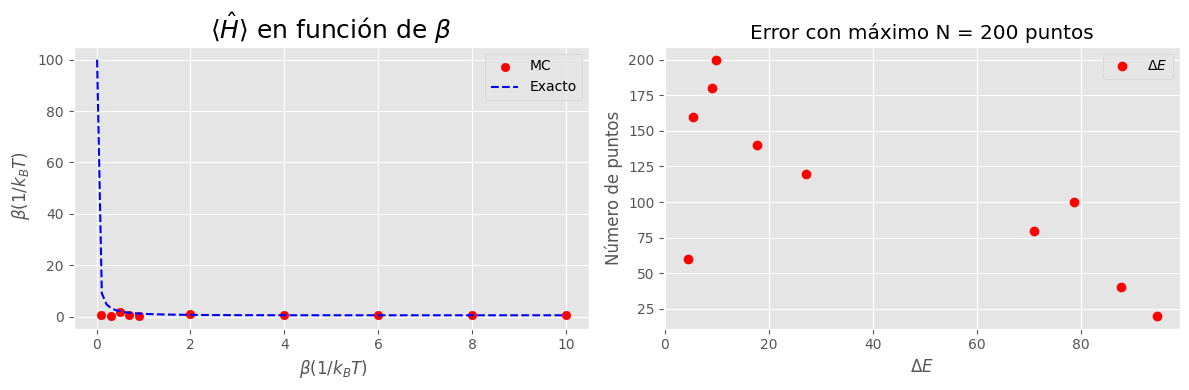

In [78]:
plot(H_avg2, percent_diff2, num_steps2, betas_1, betas_2)

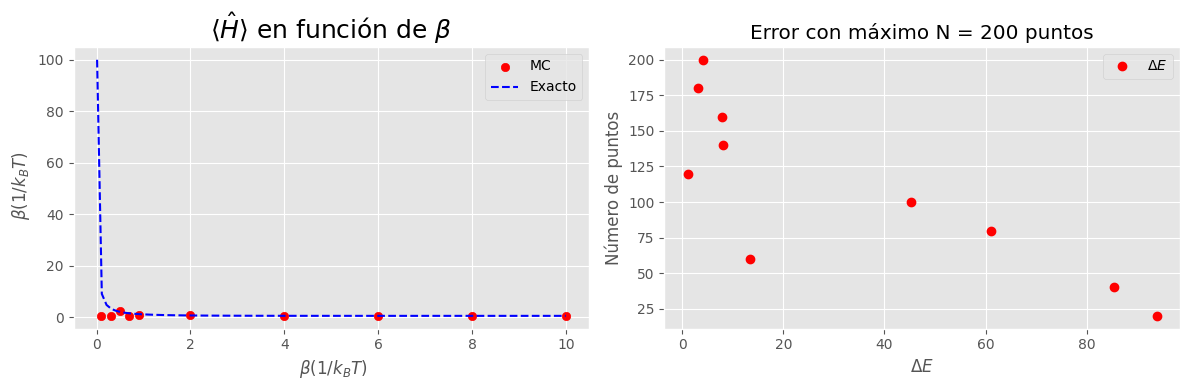

In [79]:
plot(H_avg3, percent_diff3, num_steps3, betas_1, betas_2)

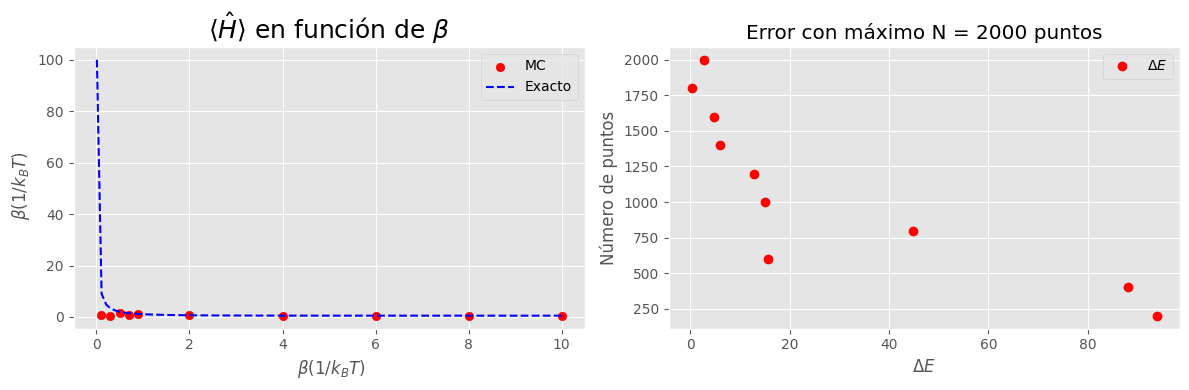

In [80]:
plot(H_avg4, percent_diff4, num_steps4, betas_1, betas_2)

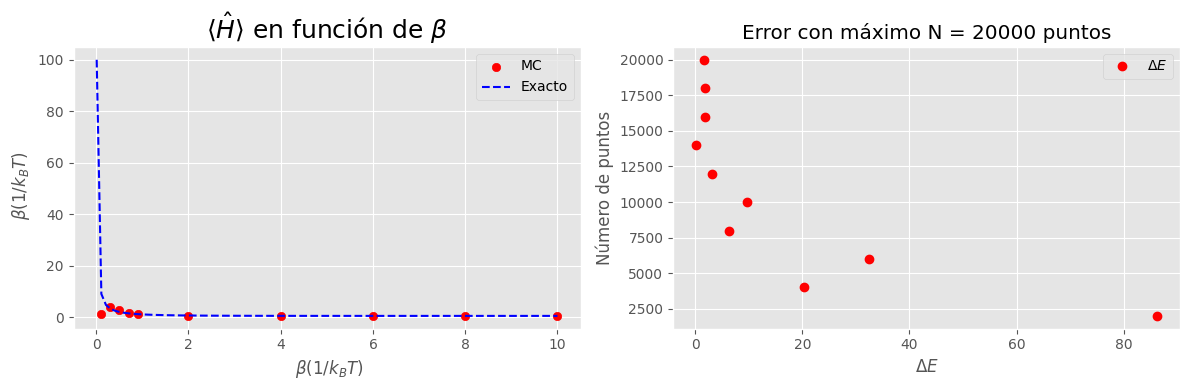

In [81]:
plot(H_avg5, percent_diff5, num_steps5, betas_1, betas_2)

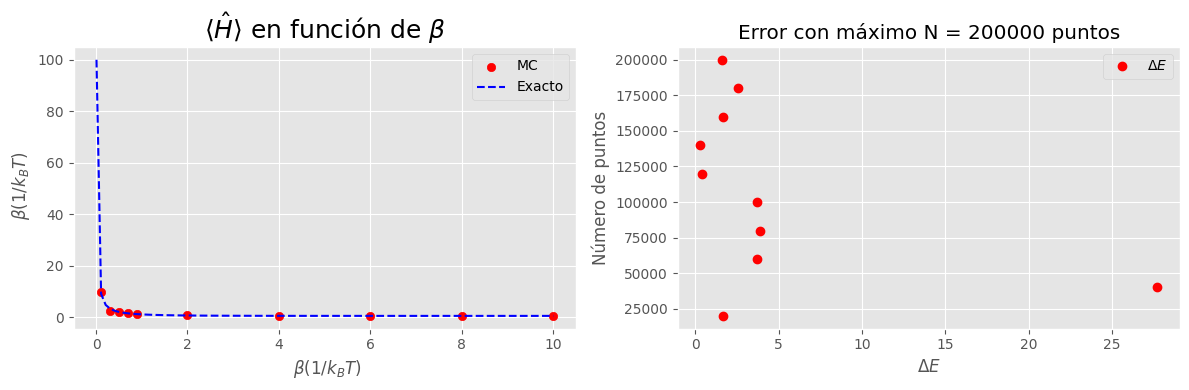

In [82]:
plot(H_avg6, percent_diff6, num_steps6, betas_1, betas_2)